In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos GDL

In [21]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf_gdl = aup.gdf_from_db(table,schema)
print(gdf_gdl.shape)
gdf_gdl.head(2)

(8499, 4)


,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."


In [23]:
gdf_gdl.Tipo.unique()

array(['Parque', 'Espacio verde vecinal', 'Área natural',
       'Unidad deportiva', 'Plaza', 'Área natural protegida'],
      dtype=object)

In [22]:
gdf_gdl = gdf_gdl.loc[(gdf_gdl.Tipo!='Glorieta')&(gdf_gdl.Tipo!='Camellón')].copy()
print(gdf_gdl.shape)

(4100, 4)


## Espacios Públicos QRO

In [24]:
schema = 'espacios_publicos'
table = 'ep_qro'
gdf_qro = aup.gdf_from_db(table,schema)
print(gdf_qro.shape)
gdf_qro.head(2)

(4814, 9)


,geografico,nombre,tipo,cveserv,cvegeo,geometria,fechaact,condicion,geometry
0,Bordo,Ninguno,No Aplica,036,220010001,Area,12/2007,No Aplica,"POLYGON ((-100.14119 20.18851, -100.14112 20.1..."
1,Bordo,Ninguno,No Aplica,037,220010001,Area,12/2007,No Aplica,"POLYGON ((-100.13606 20.18186, -100.13603 20.1..."


In [25]:
gdf_qro.tipo.unique()

array(['No Aplica', 'Intermitente', 'CamellÃ\xa0n', 'Lienzo Charro',
       'Otro', 'Glorieta', 'Urbana', 'CamellÃ³n', 'Perenne',
       'Zona Industrial', 'Tanque Elevado', 'Granja o Establo',
       'Tiradero', 'Caja de Agua', 'Diverso', 'Monumento u Obelisco',
       'Planta de Tratamiento de Agua'], dtype=object)

Eliminar Querétaro

## Espacios Públicos CDMX

In [26]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
gdf_cdmx = aup.gdf_from_db(table,schema)
print(gdf_cdmx.shape)
gdf_cdmx.head(2)

(11609, 13)


,id,geo_point_2d,geo_shape,subcat_sed,subcve_sed,gid,cve_delg,delegacion,categoria,superficie,perimetro,cve_sedema,geometry
0,0,"19.4877568178,-99.2060645931","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Panteones,604,268,2,Azcapotzalco,Equipamientos urbanos con vegetación,6660.027554,329.264738,600,"POLYGON ((-99.20639 19.48819, -99.20556 19.487..."
1,1,"19.3887689803,-99.116393168","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Deportivos,601,87,8,Iztacalco,Equipamientos urbanos con vegetación,2917.257837,272.2436142,600,"POLYGON ((-99.11679 19.38904, -99.11637 19.388..."


In [27]:
gdf_cdmx.categoria.unique()

array(['Equipamientos urbanos con vegetación',
       'Áreas verdes complementarias o ligadas a la red vial',
       'Plazas y jardines', 'Parques, arboledas y alamedas',
       'Áreas verdes urbanas fragmentadas',
       'Áreas verdes con estructura urbana',
       'Áreas con categoría de protección',
       'Áreas con vegetación reminisciente',
       'Áreas con características de protección'], dtype=object)

In [28]:
gdf_cdmx.subcat_sed.unique()

array(['Panteones', 'Deportivos', 'Camellones centrales y laterales',
       'Unidades habitacionales', 'Instituciones académicas públicas',
       'Plazas', 'Asistencia Social con vegetación CDMX', 'Parques',
       'Veg. Arbórea, arbustiva y herbácea de glorietas', 'Vialidades',
       'Instituciones académicas privadas', 'Arboledas',
       'Instituciones de salud pub/priv', 'Jardines públicos', 'Canales',
       'Jardineras públicas y privadas', 'Azoteas verdes', 'Bordos',
       'Terrenos baldíos', 'AVA', 'Depresiones orográficas', 'ANP',
       'Alamedas', 'Promontorios', 'Colinas', 'Cerros',
       'Zona de recarga de manto acuíferos'], dtype=object)

<Axes: >

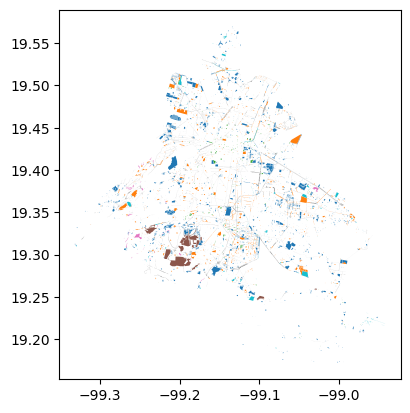

In [29]:
gdf_cdmx.plot('categoria')

## Juntamos en un dataset

In [8]:
gdf_gdl = gdf_gdl.set_crs("EPSG:4326", allow_override=True)
gdf_qro = gdf_qro.set_crs("EPSG:4326", allow_override=True)
gdf_cdmx = gdf_cdmx.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)
print("CRS of gdf_qro:", gdf_qro.crs)
print("CRS of gdf_cdmx:", gdf_cdmx.crs)

CRS of gdf_gdl: EPSG:4326
CRS of gdf_qro: EPSG:4326
CRS of gdf_cdmx: EPSG:4326


In [9]:
geodataframes = [gdf_gdl, gdf_qro, gdf_cdmx]
gdf = pd.concat(geodataframes)
gdf = gdf['geometry']
gdf.head()

0    POLYGON ((672507.028 2272132.2013, 672520.1256...
1    POLYGON ((672520.1256 2272170.353, 672507.028 ...
2    POLYGON ((672494.3253 2272095.2051, 672480.366...
3    POLYGON ((672480.3663 2272060.7314, 672494.325...
4    POLYGON ((672468.7172 2272020.6127, 672456.895...
Name: geometry, dtype: geometry

In [10]:
gdf.shape

(24922,)

## Filter public space data

(4100, 4)

## Hexágonos 3 ciudades

In [11]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
hex_table_tempt = "temperature_analysis_hex"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Querétaro'
n = '11'
query = f"""
SELECT h1.hex_id, h1.geometry, h1.city 
FROM {hex_schema}.{hex_table} h1
JOIN {hex_schema}.{hex_table_tempt} h2
ON h1.hex_id = h2.hex_id
WHERE h1.city IN ('{c1}', '{c2}') AND h1.res = {n}
"""
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b4995b80cf0fff,"POLYGON ((-99.13594 19.45127, -99.13576 19.451...",CDMX
1,8b4995b84825fff,"POLYGON ((-99.15068 19.42339, -99.15050 19.423...",CDMX
2,8b4995b84915fff,"POLYGON ((-99.14918 19.42128, -99.14901 19.421...",CDMX
3,8b4995b84959fff,"POLYGON ((-99.15271 19.42482, -99.15253 19.425...",CDMX
4,8b4995b8488bfff,"POLYGON ((-99.14702 19.42762, -99.14685 19.427...",CDMX


In [12]:
hex_gdl.shape

(807653, 3)

In [13]:
hex_gdl['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [14]:
contador_gdll = np.sum(hex_gdl['city'] == 'Guadalajara')
contador_cdmxx = np.sum(hex_gdl['city'] == 'CDMX')
#contador_qroo = np.sum(hex_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdll} \nNúmero de hexágonos Cdmx: {contador_cdmxx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


In [15]:
hex_gdl = hex_gdl.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


In [16]:
contador_gdl = np.sum(hex_gdl['city'] == 'Guadalajara')
contador_cdmx = np.sum(hex_gdl['city'] == 'CDMX')
#contador_qro = np.sum(hex_gdf['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [17]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl.head()

,hex_id,geometry,city,EspPublico
0,8b4995b80cf0fff,"POLYGON ((-99.13594 19.45127, -99.13576 19.451...",CDMX,0
1,8b4995b84825fff,"POLYGON ((-99.15068 19.42339, -99.15050 19.423...",CDMX,0
2,8b4995b84915fff,"POLYGON ((-99.14918 19.42128, -99.14901 19.421...",CDMX,1
3,8b4995b84959fff,"POLYGON ((-99.15271 19.42482, -99.15253 19.425...",CDMX,0
4,8b4995b8488bfff,"POLYGON ((-99.14702 19.42762, -99.14685 19.427...",CDMX,0


In [18]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 708008 
Número de Hexágonos con Espacios Públicos: 99645
Número total de Hexágonos: 807653


## Hexágonos con info de humedad, vegetación y temperatura

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  in ('Queretaro','Guadalajara','ZMVM') and ndmi.res = 11

In [19]:
'''import psycopg2

#Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

#Ejecutar la consulta para obtener los nombres de las columnas
cur.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_schema = 'raster_analysis' 
    AND table_name = 'temperature_analysis_hex';
""")

#Obtener los resultados
columns = cur.fetchall()

#Imprimir los nombres de las columnas
for column in columns:
    print(column[0])

cur.close()
conn.close()'''

'import psycopg2\n\n#Conectar a la base de datos\nconn = psycopg2.connect(\n    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",\n    database = "postgres",\n    user= "odc_writer",\n    password = "writejacobs1918"\n)\n\ncur = conn.cursor()\n\n#Ejecutar la consulta para obtener los nombres de las columnas\ncur.execute("""\n    SELECT column_name \n    FROM information_schema.columns \n    WHERE table_schema = \'raster_analysis\' \n    AND table_name = \'temperature_analysis_hex\';\n""")\n\n#Obtener los resultados\ncolumns = cur.fetchall()\n\n#Imprimir los nombres de las columnas\nfor column in columns:\n    print(column[0])\n\ncur.close()\nconn.close()'

In [20]:
'''import psycopg2

#Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

#Ejecutar la consulta para obtener los nombres de las columnas
cur.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_schema = 'raster_analysis' 
    AND table_name = 'ndvi_analysis_hex';
""")

#Obtener los resultados
columns = cur.fetchall()

#Imprimir los nombres de las columnas
for column in columns:
    print(column[0])

cur.close()
conn.close()'''

'import psycopg2\n\n#Conectar a la base de datos\nconn = psycopg2.connect(\n    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",\n    database = "postgres",\n    user= "odc_writer",\n    password = "writejacobs1918"\n)\n\ncur = conn.cursor()\n\n#Ejecutar la consulta para obtener los nombres de las columnas\ncur.execute("""\n    SELECT column_name \n    FROM information_schema.columns \n    WHERE table_schema = \'raster_analysis\' \n    AND table_name = \'ndvi_analysis_hex\';\n""")\n\n#Obtener los resultados\ncolumns = cur.fetchall()\n\n#Imprimir los nombres de las columnas\nfor column in columns:\n    print(column[0])\n\ncur.close()\nconn.close()'

In [21]:
import psycopg2

#Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

#Ejecutar la consulta para obtener los nombres de las columnas
cur.execute("""
    SELECT DISTINCT res
    FROM raster_analysis.temperature_analysis_hex
    WHERE city = 'Guadalajara'
""")

#Obtener los resultados
columns = cur.fetchall()

#Imprimir los nombres de las columnas
for column in columns:
    print(column[0])

cur.close()
conn.close()

11


In [22]:
hex_schema = "raster_analysis"
hex_schema_pob = "hexgrid"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_tempt = "temperature_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
temp = "temp"
poblation = "POBTOT"
hex_id = "hex_id"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Queretaro'
n = '11'

query = f'''
SELECT 
    temp.hex_id, 
    temp.city, 
    temp.geometry AS geometry,  
    temp.res AS temp_res,
    ndmi.geometry AS ndmi_geometry, 
    ndmi.city AS ndmi_city, 
    ndmi.res AS ndmi_res, 
    ndvi.geometry AS ndvi_geometry, 
    ndvi.city AS ndvi_city, 
    ndvi.res AS ndvi_res, 
    ndvi.ndvi_mean, 
    ndvi.ndvi_std, 
    ndvi.ndvi_median, 
    ndvi.ndvi_max, 
    ndvi.ndvi_min, 
    ndvi.ndvi_diff, 
    ndvi.ndvi_tend,
    ndmi.ndmi_mean, 
    ndmi.ndmi_median, 
    ndmi.ndmi_diff, 
    temp.temp_diff_mean
FROM 
    {hex_schema}.{hex_table_tempt} temp  
INNER JOIN 
    {hex_schema}.{hex_table} ndmi 
    ON temp.hex_id = ndmi.hex_id
INNER JOIN 
    {hex_schema}.{hex_tablee} ndvi 
    ON ndmi.hex_id = ndvi.hex_id
WHERE 
    temp.city IN ('{c1}', '{c2}') 
    AND temp.res = {n}
'''

intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b4995b8ec2afff,CDMX,"POLYGON ((-99.15481 19.48660, -99.15464 19.486...",11,0103000020E61000000100000007000000015DB775E8C9...,CDMX,11,0103000020E61000000100000007000000015DB775E8C9...,CDMX,11,...,0.011216,0.041535,0.056212,0.027292,0.028920,-0.000275,-0.044624,-0.047098,0.041608,2.292706
1,8b499584e521fff,CDMX,"POLYGON ((-99.17278 19.32573, -99.17260 19.325...",11,0103000020E6100000010000000700000089CC52CF0ECB...,CDMX,11,0103000020E6100000010000000700000089CC52CF0ECB...,CDMX,11,...,0.026481,0.085590,0.103649,0.074508,0.029141,-0.001131,-0.042399,-0.045157,0.052605,-0.195719
2,8b4995b8e70efff,CDMX,"POLYGON ((-99.15580 19.49936, -99.15563 19.499...",11,0103000020E610000001000000070000002DA908ABF8C9...,CDMX,11,0103000020E610000001000000070000002DA908ABF8C9...,CDMX,11,...,0.049540,0.171305,0.179916,0.111704,0.068211,-0.001869,-0.020586,-0.025474,0.030136,3.780892
3,8b4995b8e76dfff,CDMX,"POLYGON ((-99.16012 19.50030, -99.15994 19.500...",11,0103000020E61000000100000007000000FA9A06563FCA...,CDMX,11,0103000020E61000000100000007000000FA9A06563FCA...,CDMX,11,...,0.031309,0.106251,0.145233,0.081774,0.063459,-0.001065,-0.045281,-0.045453,0.025058,3.992745
4,8b4995b8cda6fff,CDMX,"POLYGON ((-99.17427 19.47356, -99.17409 19.473...",11,0103000020E6100000010000000700000067D38F2A27CB...,CDMX,11,0103000020E6100000010000000700000067D38F2A27CB...,CDMX,11,...,0.014784,0.071751,0.078055,0.057114,0.020941,-0.000562,-0.027944,-0.027051,0.023048,-0.514585
5,8b4995b8132bfff,CDMX,"POLYGON ((-99.16923 19.47474, -99.16906 19.474...",11,0103000020E61000000100000007000000F623BCB3D4CA...,CDMX,11,0103000020E61000000100000007000000F623BCB3D4CA...,CDMX,11,...,0.010429,0.011768,0.025641,-0.002762,0.028404,-0.000255,-0.038303,-0.037485,0.019384,3.091607
6,8b4995b81348fff,CDMX,"POLYGON ((-99.17154 19.47741, -99.17137 19.477...",11,0103000020E61000000100000007000000A231E590FACA...,CDMX,11,0103000020E61000000100000007000000A231E590FACA...,CDMX,11,...,0.026881,0.006398,0.032253,0.003382,0.028871,-0.001012,-0.122721,-0.122510,0.036209,1.330539
7,8b4995b33a06fff,CDMX,"POLYGON ((-99.27237 19.36075, -99.27219 19.360...",11,0103000020E610000001000000070000003F4EE5786ED1...,CDMX,11,0103000020E610000001000000070000003F4EE5786ED1...,CDMX,11,...,0.033145,0.099599,0.135074,0.063386,0.071688,-0.001213,-0.009511,-0.009518,0.037448,0.030985
8,8b4995b10258fff,CDMX,"POLYGON ((-99.24484 19.40531, -99.24466 19.405...",11,0103000020E610000001000000070000009A135A64ABCF...,CDMX,11,0103000020E610000001000000070000009A135A64ABCF...,CDMX,11,...,0.071299,0.301554,0.309987,0.248099,0.061887,-0.002809,0.016877,0.020764,0.060806,-3.920603
9,8b4995b15446fff,CDMX,"POLYGON ((-99.25334 19.38771, -99.25316 19.387...",11,0103000020E61000000100000007000000B2DB22B136D0...,CDMX,11,0103000020E61000000100000007000000B2DB22B136D0...,CDMX,11,...,0.033538,0.103379,0.125628,0.074213,0.051415,-0.001147,-0.008728,-0.007039,0.031211,-3.354773


In [23]:
intt_gdl.shape

(807653, 21)

In [24]:
intt_gdl['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [25]:
intt_gdll = np.sum(intt_gdl['city'] == 'Guadalajara')
intt_cdmxx = np.sum(intt_gdl['city'] == 'CDMX')
#intt_qroo = np.sum(intt_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {intt_gdll} \nNúmero de hexágonos Cdmx: {intt_cdmxx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


## Intersección

In [26]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [27]:
inter = gpd.sjoin(hex_gdl, intt_gdl, op='intersects')

In [28]:
inter.drop(columns=['index_right','city_right','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b4995b80cf0fff,"POLYGON ((-99.13594 19.45127, -99.13576 19.451...",CDMX,0,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,...,0.064012,0.266364,0.296017,0.210563,0.085454,-0.002134,0.003337,0.002625,0.039176,1.283257
35464,8b4995b80cf6fff,"POLYGON ((-99.13553 19.45098, -99.13536 19.451...",CDMX,0,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,...,0.064012,0.266364,0.296017,0.210563,0.085454,-0.002134,0.003337,0.002625,0.039176,1.283257
119753,8b4995b80cf5fff,"POLYGON ((-99.13641 19.45107, -99.13623 19.451...",CDMX,0,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,...,0.064012,0.266364,0.296017,0.210563,0.085454,-0.002134,0.003337,0.002625,0.039176,1.283257
133143,8b4995b80c1bfff,"POLYGON ((-99.13647 19.45059, -99.13629 19.450...",CDMX,0,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,...,0.064012,0.266364,0.296017,0.210563,0.085454,-0.002134,0.003337,0.002625,0.039176,1.283257
279166,8b4995b80c1afff,"POLYGON ((-99.13607 19.45031, -99.13589 19.450...",CDMX,0,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,11,0103000020E610000001000000070000001CFB8442B4C8...,CDMX,...,0.064012,0.266364,0.296017,0.210563,0.085454,-0.002134,0.003337,0.002625,0.039176,1.283257


In [29]:
inter['temp_diff_mean'] = inter['temp_diff_mean'].fillna(0)

In [30]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'CDMX')
#contador_qro = np.sum(inter['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 4144415 
Número de hexágonos Cdmx: 2519284


In [31]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 5967752 
Número de Hexágonos con Espacios Públicos: 695947
Número total de Hexágonos: 6663699


## Submuestreo 162,410 Hexágonos Esp Púb x 162,410 Hexágonos No Esp Púb

In [32]:
num_samples = len(inter[inter['EspPublico'] == 1])

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b49958ccc66fff,"POLYGON ((-99.04079 19.37941, -99.04061 19.379...",CDMX,1,11,0103000020E61000000100000007000000310FD74A9DC2...,CDMX,11,0103000020E61000000100000007000000310FD74A9DC2...,CDMX,...,0.022995,0.095119,0.110920,0.070986,0.039933,-0.000832,-0.039190,-0.045260,0.105456,5.374735
1,8b4995b8c8b0fff,"POLYGON ((-99.18230 19.47660, -99.18212 19.476...",CDMX,1,11,0103000020E61000000100000007000000B060AB67B1CB...,CDMX,11,0103000020E61000000100000007000000B060AB67B1CB...,CDMX,...,0.044516,0.185593,0.202190,0.142571,0.059618,-0.001587,-0.031197,-0.029058,0.023261,1.119385
2,8b49958e3b75fff,"POLYGON ((-99.04173 19.32187, -99.04155 19.322...",CDMX,1,11,0103000020E61000000100000007000000184B3962B3C2...,CDMX,11,0103000020E61000000100000007000000184B3962B3C2...,CDMX,...,0.032811,0.132783,0.148701,0.096085,0.052616,-0.001115,-0.033329,-0.034870,0.034183,1.608911
3,8b499585c754fff,"POLYGON ((-99.13575 19.33108, -99.13557 19.331...",CDMX,1,11,0103000020E6100000010000000700000018329E23B1C8...,CDMX,11,0103000020E6100000010000000700000018329E23B1C8...,CDMX,...,0.068892,0.282132,0.330201,0.218837,0.111364,-0.002560,0.028023,0.023073,0.046979,-0.989339
4,8b4995b15cd0fff,"POLYGON ((-99.25328 19.38138, -99.25310 19.381...",CDMX,1,11,0103000020E61000000100000007000000EF6C9C5B3DD0...,CDMX,11,0103000020E61000000100000007000000EF6C9C5B3DD0...,CDMX,...,0.065158,0.175834,0.261605,0.119403,0.142202,-0.001668,-0.013008,-0.010599,0.101310,0.554899


In [33]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 695947 
Número de Hexágonos con Espacios Públicos: 695947
Número total de Hexágonos: 1391894


In [34]:
inter.shape

(1391894, 22)

In [35]:
'''import psycopg2

# Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

# Ejecutar la consulta para obtener el esquema de la tabla
table_name = 'hex_censo_mza_2020_res9'
cur.execute(f"""
    SELECT table_schema
    FROM information_schema.tables
    WHERE table_name = '{table_name}';
""")

# Obtener los resultados
schema = cur.fetchone()
print(f"El esquema de la tabla {table_name} es: {schema[0]}")

cur.close()
conn.close()'''

'import psycopg2\n\n# Conectar a la base de datos\nconn = psycopg2.connect(\n    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",\n    database = "postgres",\n    user= "odc_writer",\n    password = "writejacobs1918"\n)\n\ncur = conn.cursor()\n\n# Ejecutar la consulta para obtener el esquema de la tabla\ntable_name = \'hex_censo_mza_2020_res9\'\ncur.execute(f"""\n    SELECT table_schema\n    FROM information_schema.tables\n    WHERE table_name = \'{table_name}\';\n""")\n\n# Obtener los resultados\nschema = cur.fetchone()\nprint(f"El esquema de la tabla {table_name} es: {schema[0]}")\n\ncur.close()\nconn.close()'

In [36]:
hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
n = "9"
t = "urban"

#Consulta para la tabla de población (solo tipo urbano y ciudades seleccionadas):
query_pob = f"""
SELECT * 
FROM {hex_schema_pob}.{hex_table_pob} 
WHERE city IN ('{c1}', '{c2}') 
AND type = '{t}'
"""

hex_gdl_pob = aup.gdf_from_query(query_pob, geometry_col='geometry')
hex_gdl_pob.head(5)

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban
2,89498c97333ffff,"POLYGON ((-103.27379 20.66284, -103.27257 20.6...",14039,Guadalajara,Guadalajara,urban
3,89498c96063ffff,"POLYGON ((-103.33352 20.63689, -103.33230 20.6...",14039,Guadalajara,Guadalajara,urban
4,89498c95cb3ffff,"POLYGON ((-103.29386 20.71601, -103.29264 20.7...",14039,Guadalajara,Guadalajara,urban


In [37]:
'''import psycopg2

conn = psycopg2.connect(
    host="hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database="postgres",
    user="odc_writer",
    password="writejacobs1918"
)

cur = conn.cursor()

table_name = 'hex_censo_mza_2020_res9'

cur.execute(f"""
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = '{table_name}';
""")

columns = cur.fetchall()
for column in columns:
    print(column[0])

# Cerrar cursor y conexión
cur.close()
conn.close()'''



'import psycopg2\n\nconn = psycopg2.connect(\n    host="hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",\n    database="postgres",\n    user="odc_writer",\n    password="writejacobs1918"\n)\n\ncur = conn.cursor()\n\ntable_name = \'hex_censo_mza_2020_res9\'\n\ncur.execute(f"""\n    SELECT column_name\n    FROM information_schema.columns\n    WHERE table_name = \'{table_name}\';\n""")\n\ncolumns = cur.fetchall()\nfor column in columns:\n    print(column[0])\n\n# Cerrar cursor y conexión\ncur.close()\nconn.close()'

In [38]:
#Consulta para la tabla de manzanas (solo ciudades seleccionadas):
query_mza = f"""
SELECT hex_id_9, pobtot, geometry
FROM {hex_schema_mza}.{hex_table_mza} 
"""

hex_gdl_mza = aup.gdf_from_query(query_mza, geometry_col='geometry')

In [39]:
pob = hex_gdl_pob.shape
mza = hex_gdl_mza.shape

print(pob)
print(mza)

(13629, 6)
(119059, 3)


In [40]:
hex_gdl_pob['city'].unique()

array(['Guadalajara', 'CDMX'], dtype=object)

In [41]:
hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
t = "urban"


query_join = f"""
SELECT pob.hex_id_9, pob.city, pob.type, mza.pobtot, mza.geometry
FROM {hex_schema_pob}.{hex_table_pob} pob
INNER JOIN {hex_schema_mza}.{hex_table_mza} mza
ON pob.hex_id_9 = mza.hex_id_9
WHERE pob.city IN ('{c1}', '{c2}') 
AND pob.type = '{t}'
"""

hex_gdl_join = aup.gdf_from_query(query_join, geometry_col='geometry')

hex_gdl_join.head(5)


,hex_id_9,city,type,pobtot,geometry
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387..."
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.34790, -99.30650 19.349..."
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284..."
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376..."
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330..."


In [42]:
contador_gdl_join = np.sum(hex_gdl_join['city'] == 'Guadalajara')
contador_cdmxx_join = np.sum(hex_gdl_join['city'] == 'CDMX')
print(f'Número de hexágonos Gdl: {contador_gdl_join} \nNúmero de hexágonos Cdmx: {contador_cdmxx_join}')

Número de hexágonos Gdl: 5650 
Número de hexágonos Cdmx: 6165


In [43]:
hex_gdl_join = hex_gdl_join.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [44]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl_join['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl_join.head()

,hex_id_9,city,type,pobtot,geometry,EspPublico
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387...",1
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.34790, -99.30650 19.349...",0
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284...",1
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376...",1
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330...",1


In [45]:
contador_ceros_join = np.sum(hex_gdl_join['EspPublico'] == 0)
contador_uno_join = np.sum(hex_gdl_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 7364 
Número de Hexágonos con Espacios Públicos: 4451
Número total de Hexágonos: 11815


## Intersección espacial

In [46]:
pd.isna(hex_gdl_join).sum()

hex_id_9      0
city          0
type          0
pobtot        0
geometry      0
EspPublico    0
dtype: int64

In [47]:
hex_gdl_pob = hex_gdl_pob.set_crs("EPSG:4326")
hex_gdl_mza = hex_gdl_mza.set_crs("EPSG:4326")

In [48]:
inter_join = gpd.sjoin(hex_gdl_pob, hex_gdl_mza, op='intersects')
print(inter_join)

         hex_id_9_left                                           geometry  \
0      89498c96e0bffff  POLYGON ((-103.35267 20.66765, -103.35145 20.6...   
82     89498c96ecfffff  POLYGON ((-103.35003 20.66229, -103.34881 20.6...   
333    89498c96e47ffff  POLYGON ((-103.34935 20.66910, -103.34813 20.6...   
389    89498c96e1bffff  POLYGON ((-103.35301 20.66425, -103.35179 20.6...   
721    89498c96e57ffff  POLYGON ((-103.34969 20.66569, -103.34847 20.6...   
...                ...                                                ...   
13594  894995b96d3ffff  POLYGON ((-99.05118 19.43500, -99.04994 19.436...   
13534  894995b96cfffff  POLYGON ((-99.05030 19.44172, -99.04906 19.443...   
13550  894995b9657ffff  POLYGON ((-99.04985 19.44507, -99.04861 19.446...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   

      CVEGEO               NOMGEO         city   type  index_right  \
0    

In [49]:
inter_join.drop(columns=['index_right', 'hex_id_9_right'], inplace=True)
inter_join.rename(columns={"hex_id_9_left": "hex_id_9"}, inplace=True)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
82,89498c96ecfffff,"POLYGON ((-103.35003 20.66229, -103.34881 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
333,89498c96e47ffff,"POLYGON ((-103.34935 20.66910, -103.34813 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
389,89498c96e1bffff,"POLYGON ((-103.35301 20.66425, -103.35179 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
721,89498c96e57ffff,"POLYGON ((-103.34969 20.66569, -103.34847 20.6...",14039,Guadalajara,Guadalajara,urban,975.0


In [50]:
pd.isna(inter_join).sum()

hex_id_9    0
geometry    0
CVEGEO      0
NOMGEO      0
city        0
type        0
pobtot      0
dtype: int64

In [51]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = inter_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

inter_join['EspPublico'] = intersects_public_spaces.astype(int)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot,EspPublico
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
82,89498c96ecfffff,"POLYGON ((-103.35003 20.66229, -103.34881 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
333,89498c96e47ffff,"POLYGON ((-103.34935 20.66910, -103.34813 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
389,89498c96e1bffff,"POLYGON ((-103.35301 20.66425, -103.35179 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
721,89498c96e57ffff,"POLYGON ((-103.34969 20.66569, -103.34847 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0


In [52]:
cont_ceros_join = np.sum(inter_join['EspPublico'] == 0)
cont_uno_join = np.sum(inter_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno_join}\nNúmero total de Hexágonos: {cont_ceros_join + cont_uno_join}')

Números de hexagonos sin Espacios Públicos: 49764 
Número de Hexágonos con Espacios Públicos: 30868
Número total de Hexágonos: 80632


## Submuestreo población

In [53]:
num_samples_join = len(inter_join[inter_join['EspPublico'] == 1])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = inter_join[inter_join['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = inter_join[inter_join['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
inter_join = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
inter_join.reset_index(drop = True, inplace = True)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot,EspPublico
0,8949958518bffff,"POLYGON ((-99.11824 19.30248, -99.11700 19.304...",09003,Coyoacán,CDMX,urban,1007.0,1
1,89499585b53ffff,"POLYGON ((-99.12210 19.36758, -99.12086 19.369...",09007,Iztapalapa,CDMX,urban,2065.0,1
2,89499585287ffff,"POLYGON ((-99.08155 19.29861, -99.08031 19.300...",09007,Iztapalapa,CDMX,urban,1755.0,1
3,8949958eb2fffff,"POLYGON ((-99.07006 19.38592, -99.06882 19.387...",09006,Iztacalco,CDMX,urban,3394.0,1
4,8949958455bffff,"POLYGON ((-99.17397 19.27941, -99.17273 19.280...",09012,Tlalpan,CDMX,urban,1429.0,1


In [54]:
contador_ceros_join = np.sum(inter_join['EspPublico'] == 0)
contador_uno_join = np.sum(inter_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 30868 
Número de Hexágonos con Espacios Públicos: 30868
Número total de Hexágonos: 61736


In [55]:
inter_join.shape

(61736, 8)

## Intersección espacial con población, vegetación, humedad y temperatura.

In [56]:
gdl_samples_inter = 222941
cdmx_samples_inter = 180886


# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = inter[inter['city'] == 'Guadalajara'].sample(n=gdl_samples_inter, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = inter[inter['city'] == 'CDMX'].sample(n=cdmx_samples_inter, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_Guadalajara, sample_with_Cdmx])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b49ab4a2761fff,"POLYGON ((-103.46140 20.74234, -103.46122 20.7...",Guadalajara,0,11,0103000020E6100000010000000700000011F73E9087DD...,Guadalajara,11,0103000020E6100000010000000700000011F73E9087DD...,Guadalajara,...,0.196324,0.313934,0.686440,0.143196,0.543244,-0.000868,-0.004237,-0.057025,0.474585,1.637735
1,8b49ab4960c4fff,"POLYGON ((-103.36781 20.77978, -103.36763 20.7...",Guadalajara,0,11,0103000020E61000000100000007000000270C082091D7...,Guadalajara,11,0103000020E61000000100000007000000270C082091D7...,Guadalajara,...,0.126909,0.720346,0.744929,0.596078,0.148851,-0.004267,0.162811,0.159931,0.082315,-4.371524
2,8b498c9446d1fff,"POLYGON ((-103.30738 20.67617, -103.30720 20.6...",Guadalajara,0,11,0103000020E610000001000000070000006B0ABD47A4D3...,Guadalajara,11,0103000020E610000001000000070000006B0ABD47A4D3...,Guadalajara,...,0.035641,0.186702,0.204319,0.151394,0.052925,-0.001061,-0.050604,-0.048989,0.035194,1.532847
3,8b49aa2c3789fff,"POLYGON ((-103.31883 20.55254, -103.31866 20.5...",Guadalajara,0,11,0103000020E6100000010000000700000098FC2A8C6FD4...,Guadalajara,11,0103000020E6100000010000000700000098FC2A8C6FD4...,Guadalajara,...,0.075117,0.219712,0.307175,0.145248,0.161927,-0.002050,-0.019775,-0.026326,0.092838,-1.708328
4,8b49aa24e934fff,"POLYGON ((-103.51139 20.47468, -103.51122 20.4...",Guadalajara,0,11,0103000020E61000000100000007000000D38D23D3B9E0...,Guadalajara,11,0103000020E61000000100000007000000D38D23D3B9E0...,Guadalajara,...,0.020924,0.123073,0.153738,0.093353,0.060386,-0.000192,-0.043428,-0.044029,0.094701,-inf


In [57]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'CDMX')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 222941 
Número de hexágonos Cdmx: 180886


In [58]:
inter = inter.set_crs("EPSG:4326")
inter_join = inter_join.set_crs("EPSG:4326")

In [59]:
# Simplificar las geometrías
inter['geometry'] = inter['geometry'].simplify(tolerance=0.01)
inter_join['geometry'] = inter_join['geometry'].simplify(tolerance=0.01)

# Realizar la intersección con geometrías simplificadas
simplified_intersection = gpd.overlay(inter, inter_join, how='intersection')


In [60]:
simplified_intersection.head()

,hex_id,city_1,EspPublico_1,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_diff,temp_diff_mean,hex_id_9,CVEGEO,NOMGEO,city_2,type,pobtot,EspPublico_2,geometry
0,8b498c90b54cfff,Guadalajara,0,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
1,8b498c90b55dfff,Guadalajara,0,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."
2,8b498c90b548fff,Guadalajara,0,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,...,0.440299,-3.715834,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19606 20.66790, -103.19576 20.6..."
3,8b498c90b54cfff,Guadalajara,0,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
4,8b498c90b55dfff,Guadalajara,0,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."


In [61]:
simplified_intersection.drop(columns=["city_1", "EspPublico_1"], inplace=True)
simplified_intersection.rename(columns={"city_2": "city", "EspPublico_2": "EspPublico"}, inplace=True)
simplified_intersection.head()

,hex_id,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,ndvi_mean,ndvi_std,...,ndmi_diff,temp_diff_mean,hex_id_9,CVEGEO,NOMGEO,city,type,pobtot,EspPublico,geometry
0,8b498c90b54cfff,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0.414017,0.217957,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
1,8b498c90b55dfff,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0.426913,0.217324,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."
2,8b498c90b548fff,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0.402150,0.215642,...,0.440299,-3.715834,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19606 20.66790, -103.19576 20.6..."
3,8b498c90b54cfff,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0.414017,0.217957,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
4,8b498c90b55dfff,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0.426913,0.217324,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."


In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = ['pobtot', 'ndvi_mean', 'ndvi_std', 'ndvi_median', 'ndvi_max', 'ndvi_min', 'ndvi_diff', 
            'ndvi_tend', 'ndmi_mean', 'ndmi_median', 'ndmi_diff', 'temp_diff_mean']

df_features = simplified_intersection[features]
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_features.fillna(df_features.mean(), inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

pca = PCA(n_components= 4)  #Cambia n_components si necesitas más o menos dimensiones
pca_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2', "PCA3", "PCA4"])

simplified_intersection = simplified_intersection.reset_index(drop=True)
simplified_intersection['PCA1'] = pca_df['PCA1']
simplified_intersection['PCA2'] = pca_df['PCA2']
simplified_intersection["PCA3"] = pca_df["PCA3"]
simplified_intersection["PCA4"] = pca_df["PCA4"]



In [63]:
# Aplicar PCA con todos los componentes
pca = PCA(n_components=len(features))
pca.fit(scaled_features)

# Varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Varianza acumulada
cumulative_variance = np.cumsum(explained_variance_ratio)

In [64]:
#Varianza explicada por cada componente:
explained_variance_ratio = pca.explained_variance_ratio_

#Varianza acumulada:
cumulative_variance = np.cumsum(explained_variance_ratio)

for i, var in enumerate(cumulative_variance):
    print(f"Componente {i+1}: Varianza acumulada = {var:.4f}")

Componente 1: Varianza acumulada = 0.6393
Componente 2: Varianza acumulada = 0.8133
Componente 3: Varianza acumulada = 0.8883
Componente 4: Varianza acumulada = 0.9406
Componente 5: Varianza acumulada = 0.9760
Componente 6: Varianza acumulada = 0.9899
Componente 7: Varianza acumulada = 0.9970
Componente 8: Varianza acumulada = 0.9984
Componente 9: Varianza acumulada = 0.9993
Componente 10: Varianza acumulada = 0.9999
Componente 11: Varianza acumulada = 1.0000
Componente 12: Varianza acumulada = 1.0000


In [65]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = simplified_intersection['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

simplified_intersection['EspPublico'] = intersects_public_spaces.astype(int)
simplified_intersection.head()

,hex_id,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,ndvi_mean,ndvi_std,...,NOMGEO,city,type,pobtot,EspPublico,geometry,PCA1,PCA2,PCA3,PCA4
0,8b498c90b54cfff,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0.414017,0.217957,...,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6...",5.865123,4.764874,0.166862,1.217243
1,8b498c90b55dfff,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0.426913,0.217324,...,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6...",5.743460,4.965595,0.112257,1.771860
2,8b498c90b548fff,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0.402150,0.215642,...,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19606 20.66790, -103.19576 20.6...",5.638006,5.102393,0.157688,1.410981
3,8b498c90b54cfff,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0.414017,0.217957,...,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6...",5.836077,4.719787,0.424034,1.272489
4,8b498c90b55dfff,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0.426913,0.217324,...,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6...",5.714413,4.920508,0.369429,1.827106


In [66]:
cont_ceros_join = np.sum(simplified_intersection['EspPublico'] == 0)
cont_uno_join = np.sum(simplified_intersection['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno_join}\nNúmero total de Hexágonos: {cont_ceros_join + cont_uno_join}')

Números de hexagonos sin Espacios Públicos: 256176 
Número de Hexágonos con Espacios Públicos: 189746
Número total de Hexágonos: 445922


### Submuestreo de todas las variables

In [67]:
num_samples_join = len(simplified_intersection[simplified_intersection['EspPublico'] == 1])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = simplified_intersection[simplified_intersection['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = simplified_intersection[simplified_intersection['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
simplified_intersection = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
simplified_intersection.reset_index(drop = True, inplace = True)
simplified_intersection.head()

,hex_id,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,ndvi_mean,ndvi_std,...,NOMGEO,city,type,pobtot,EspPublico,geometry,PCA1,PCA2,PCA3,PCA4
0,8b4995b9db2bfff,11,0103000020E61000000100000007000000529E5F8D75C9...,CDMX,11,0103000020E61000000100000007000000529E5F8D75C9...,CDMX,11,0.071472,0.014560,...,Gustavo A. Madero,CDMX,urban,0.0,1,"POLYGON ((-99.14756 19.50019, -99.14727 19.500...",-2.805139,0.198628,-1.317004,-1.211094
1,8b4995b3364efff,11,0103000020E61000000100000007000000A523332CCBD0...,CDMX,11,0103000020E61000000100000007000000A523332CCBD0...,CDMX,11,0.219618,0.068384,...,Álvaro Obregón,CDMX,urban,166.0,1,"POLYGON ((-99.26263 19.37311, -99.26234 19.373...",1.565889,-1.897381,-1.161963,-0.527244
2,8b499584418dfff,11,0103000020E61000000100000007000000574B222E8FCA...,CDMX,11,0103000020E61000000100000007000000574B222E8FCA...,CDMX,11,0.115772,0.029161,...,Tlalpan,CDMX,urban,4062.0,1,"POLYGON ((-99.16533 19.26756, -99.16580 19.267...",-2.414953,-0.538802,2.447309,-0.144075
3,8b499585678bfff,11,0103000020E61000000100000007000000A4A784E69CC4...,CDMX,11,0103000020E61000000100000007000000A4A784E69CC4...,CDMX,11,0.176869,0.058786,...,Iztapalapa,CDMX,urban,2707.0,1,"POLYGON ((-99.07242 19.29059, -99.07224 19.290...",-0.586495,-0.193333,1.295171,0.195995
4,8b499586e748fff,11,0103000020E61000000100000007000000F21D75C86ACD...,CDMX,11,0103000020E61000000100000007000000F21D75C86ACD...,CDMX,11,0.160239,0.037208,...,Tlalpan,CDMX,urban,1660.0,1,"POLYGON ((-99.20993 19.28099, -99.20964 19.280...",-1.093063,-0.583988,0.090998,0.320513


In [68]:
contador_ceros_join = np.sum(simplified_intersection['EspPublico'] == 0)
contador_uno_join = np.sum(simplified_intersection['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 189746 
Número de Hexágonos con Espacios Públicos: 189746
Número total de Hexágonos: 379492


### Clasificadores para temperatura, humedad, población, vegetación...

In [69]:
xxx = simplified_intersection[["PCA1", "PCA2", "PCA3", "PCA4"]]
yyy = simplified_intersection['EspPublico']

In [70]:
yyy.unique()

array([1, 0])

### Logistic Regression

In [71]:
x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.3, random_state = 42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

#Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  

#Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

#Escalar los datos:
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

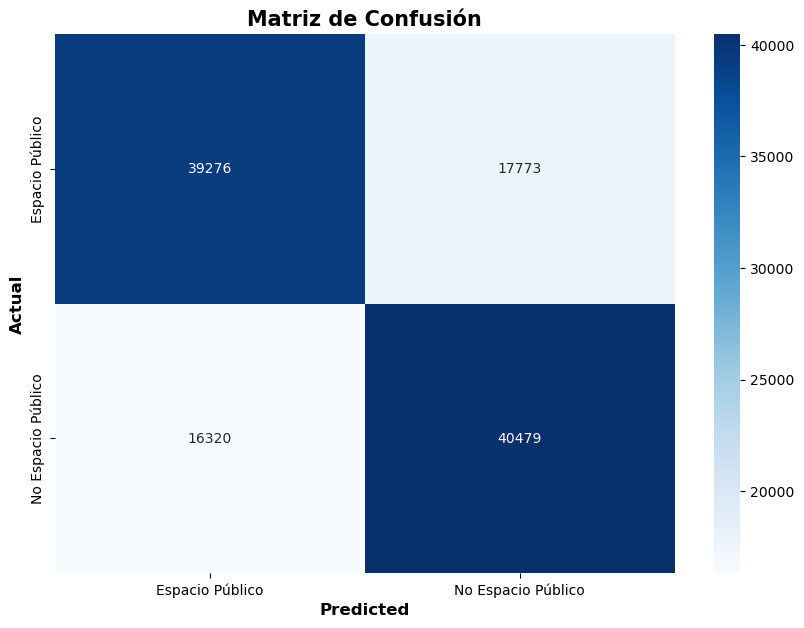

In [129]:
clf = LogisticRegression(max_iter=10000, C=1, penalty='l2', solver='sag', warm_start=True)
clf.fit(x_train_scale, y_train_clean)

y_pred = clf.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [130]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7005393155786663


In [131]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70     57049
           1       0.69      0.71      0.70     56799

    accuracy                           0.70    113848
   macro avg       0.70      0.70      0.70    113848
weighted avg       0.70      0.70      0.70    113848



In [75]:
'''from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

log_reg = LogisticRegression(max_iter=1000)

# Definir el grid de hiperparámetros a ajustar
param_dist = {
    'C': np.logspace(-2, 2, 10),  # Distribución logarítmica de C
    'penalty': ['l2'],  # Usar solo penalización l2
    'solver': ['liblinear']
}

#Usar RandomizedSearchCV:
random_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='f1', verbose=1, n_jobs=-1)

random_search.fit(x_train_scale, y_train_clean)

#Usar el mejor modelo encontrado:
best_model = random_search.best_estimator_

print("Mejores hiperparámetros encontrados:", random_search.best_params_)'''


'from sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.linear_model import LogisticRegression\nimport numpy as np\n\n# Inicializar el modelo\nlog_reg = LogisticRegression(max_iter=1000)\n\n# Definir el grid de hiperparámetros a ajustar\nparam_dist = {\n    \'C\': np.logspace(-2, 2, 10),  # Distribución logarítmica de C\n    \'penalty\': [\'l2\'],  # Usar solo penalización l2\n    \'solver\': [\'liblinear\']\n}\n\n# Usar RandomizedSearchCV en lugar de GridSearchCV\nrandom_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, \n                                   n_iter=10, cv=5, scoring=\'f1\', verbose=1, n_jobs=-1)\n\n# Ajustar el modelo\nrandom_search.fit(x_train_scale, y_train_clean)\n\n# Usar el mejor modelo encontrado\nbest_model = random_search.best_estimator_\n\n# Imprimir el mejor modelo encontrado\nprint("Mejores hiperparámetros encontrados:", random_search.best_params_)'

### Naive Bayes

In [76]:
nb3 = GaussianNB()
nb3.fit(x_train_scale, y_train_clean)

GaussianNB()

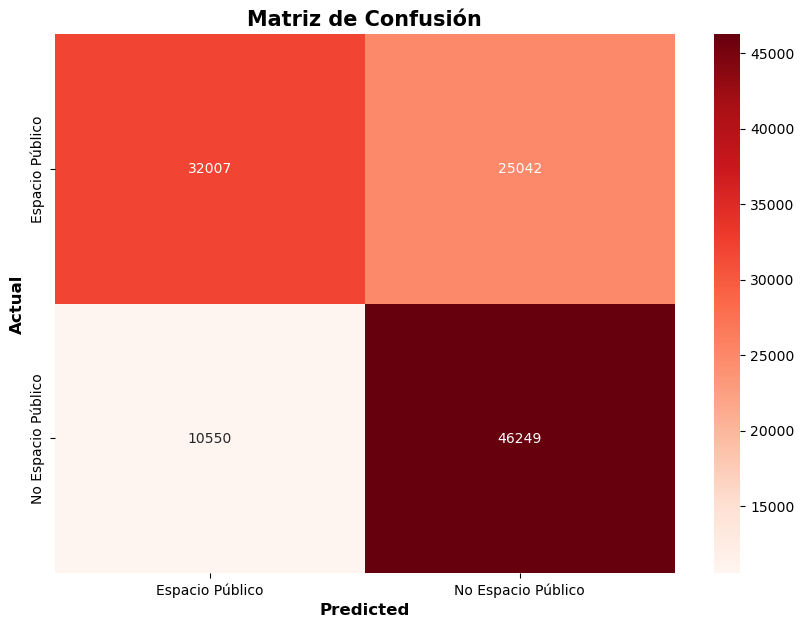

In [77]:
y_prend = nb3.predict(x_test_clean)
cm2 = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [78]:
accuracy = accuracy_score(y_test_clean, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6873726372004778


In [79]:
print(classification_report(y_test_clean, y_prend))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64     57049
           1       0.65      0.81      0.72     56799

    accuracy                           0.69    113848
   macro avg       0.70      0.69      0.68    113848
weighted avg       0.70      0.69      0.68    113848



### Random Forest Classifier

In [80]:
rf3 = RandomForestClassifier(n_estimators = 100, random_state = 123)  
rf3.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf3.predict(x_test_clean)

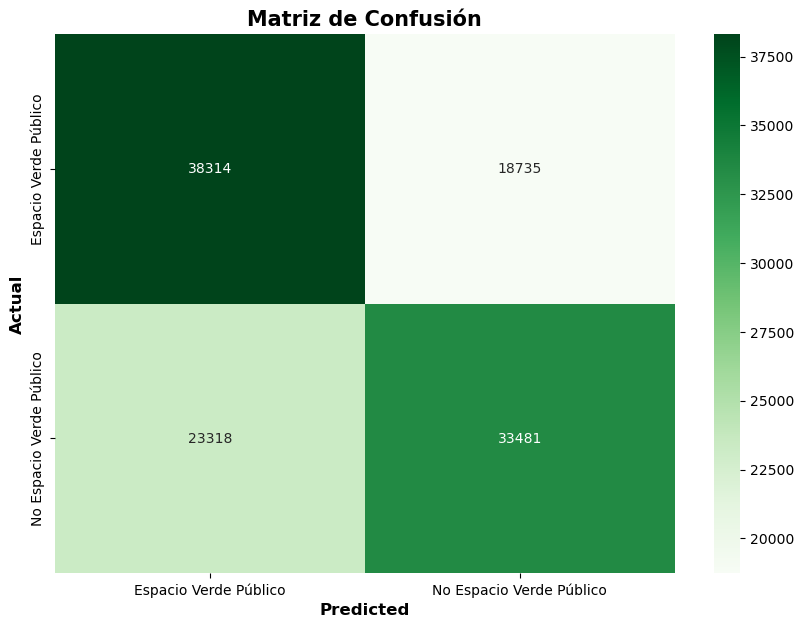

In [81]:
cm2 = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [82]:
accuracy = accuracy_score(y_test_clean, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6306215304616681


In [83]:
print(classification_report(y_test_clean, y_predd))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65     57049
           1       0.64      0.59      0.61     56799

    accuracy                           0.63    113848
   macro avg       0.63      0.63      0.63    113848
weighted avg       0.63      0.63      0.63    113848



### Ada Boost Clasifier

In [84]:
model2 = AdaBoostClassifier(n_estimators = 100)
model2.fit(x_train_scale, y_train_clean)

AdaBoostClassifier(n_estimators=100)

In [85]:
predictions2 = model2.predict(x_test_clean)
predictions2

array([0, 0, 0, ..., 1, 0, 0])

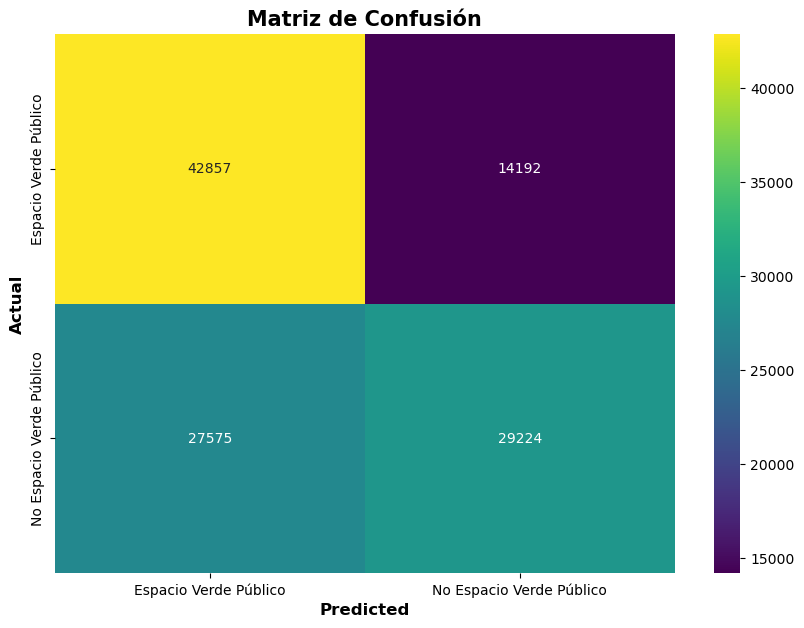

In [86]:
cm2 = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [87]:
print(classification_report(y_test_clean, predictions2))

              precision    recall  f1-score   support

           0       0.61      0.75      0.67     57049
           1       0.67      0.51      0.58     56799

    accuracy                           0.63    113848
   macro avg       0.64      0.63      0.63    113848
weighted avg       0.64      0.63      0.63    113848



### XGB Classifier

In [88]:
model22 = xgb.XGBClassifier()
model22.fit(x_train_scale, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [89]:
predictions22 = model22.predict(x_test_clean)
predictions22

array([0, 1, 1, ..., 1, 1, 1])

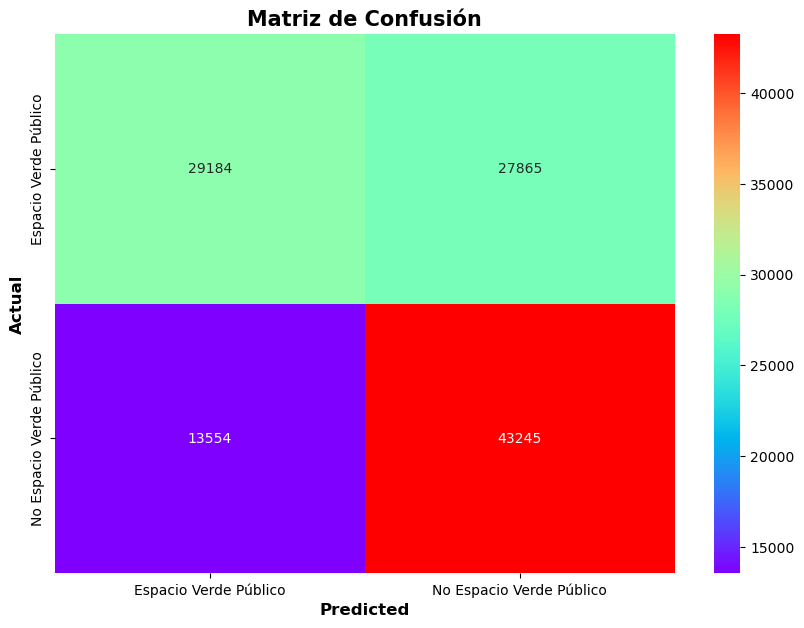

In [90]:
cm2 = confusion_matrix(y_test_clean, predictions22)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [91]:
print(classification_report(y_test_clean, predictions22))

              precision    recall  f1-score   support

           0       0.68      0.51      0.58     57049
           1       0.61      0.76      0.68     56799

    accuracy                           0.64    113848
   macro avg       0.65      0.64      0.63    113848
weighted avg       0.65      0.64      0.63    113848



In [92]:
accuracy = accuracy_score(y_test_clean, predictions22)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6361903590752582


### Decision Tree Classfier

In [93]:
from sklearn.tree import DecisionTreeClassifier

In [94]:
model32 = DecisionTreeClassifier()
model32.fit(x_train_scale, y_train_clean)

DecisionTreeClassifier()

In [95]:
predictions32 = model32.predict(x_test_clean)
predictions32

array([0, 1, 0, ..., 0, 0, 0])

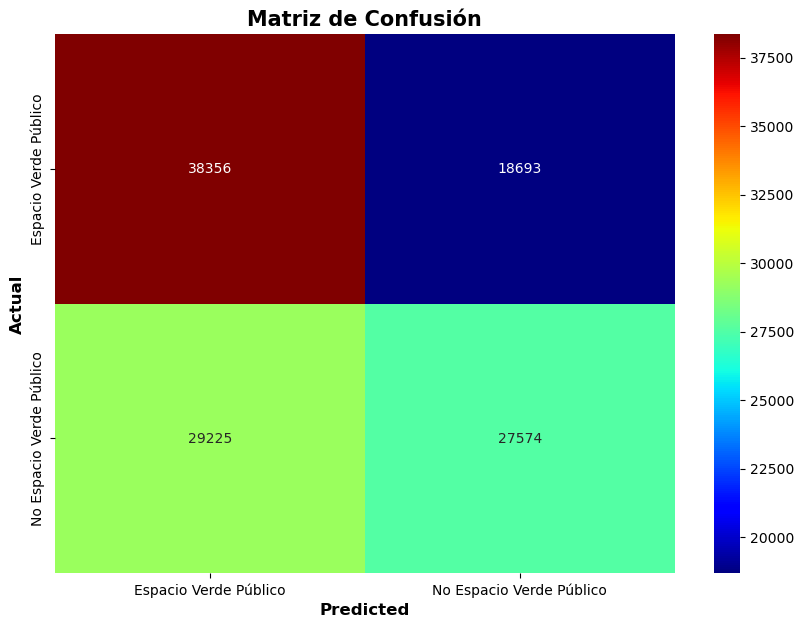

In [96]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [97]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62     57049
           1       0.60      0.49      0.54     56799

    accuracy                           0.58    113848
   macro avg       0.58      0.58      0.58    113848
weighted avg       0.58      0.58      0.58    113848



In [98]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.579105473965287


In [99]:
from sklearn.linear_model import SGDClassifier

In [100]:
modell32 = SGDClassifier()
modell32.fit(x_train_scale, y_train_clean)

SGDClassifier()

In [101]:
predictions32 = modell32.predict(x_test_clean)
predictions32

array([0, 1, 0, ..., 1, 0, 0])

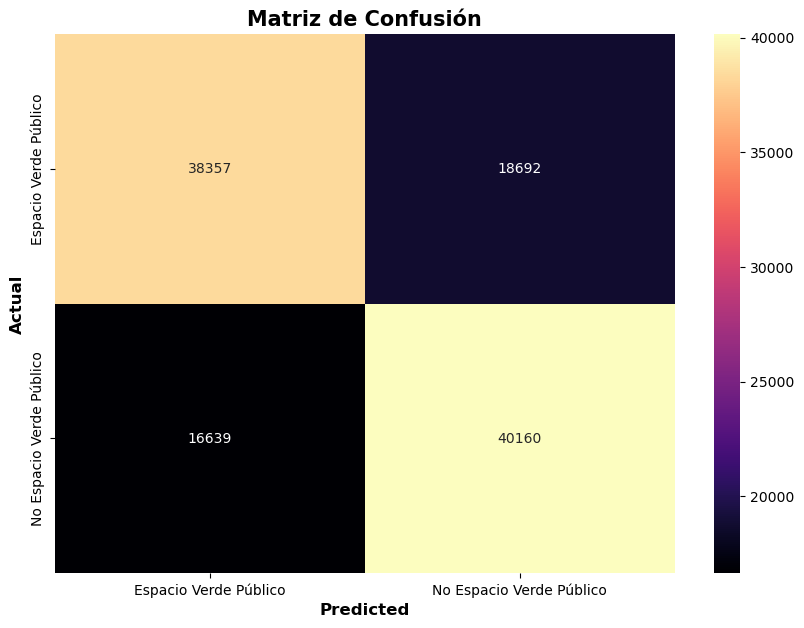

In [103]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="magma", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [104]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68     57049
           1       0.68      0.71      0.69     56799

    accuracy                           0.69    113848
   macro avg       0.69      0.69      0.69    113848
weighted avg       0.69      0.69      0.69    113848



In [105]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6896651675918769
